# Bài thực hành số 7. Sử dụng thư viện ML
*Mục tiêu*: sử dụng được các lớp cơ bản của ML: Transform, Estmator, Pipeline để xây
dựng mô hình học máy và đánh giá mô hình.

## Nội dung thực hành:

> Dự đoán khách hàng rời ngân hàng

Cho bộ dữ liệu "Churn_Modelling.csv" mô tả các thông tin khách hàng của một ngân
hàng, bao gồm:

- RowNumber: số thứ tự của mỗi dòng trong bộ dữ liệu
- CustomerId: mã số khách hàng
- Surname: họ của khách hàng
- CreditScore: điểm tín dụng của khách hàng
- Geography: quốc gia của khách hàng
- Gender: giới tính của khách hàng
- Age: tuổi của khách hàng
- Tenure: số năm khách hàng đã sử dụng dịch vụ của ngân hàng
- Balance: số tiền trong tài khoản của khách hàng
- NumOfProducts: số lượng sản phẩm mà khách hàng đã mua từ ngân hàng
- HasCrCard: có sở hữu thẻ tín dụng không (1 nếu có, 0 nếu không)
- IsActiveMember: khách hàng có đang hoạt động trong ngân hàng không (1 nếu đang hoạt động, 0 nếu không)
- EstimatedSalary: ước tính thu nhập của khách hàng
- Exited: khách hàng đã rời đi hay chưa (1 nếu đã rời đi, 0 nếu chưa)

## Yêu cầu:

a) Sử dụng PySpark để đọc dữ liệu vào DataFrame.
b) Thực hiện một số thống kê, trực quan hóa để hiểu dữ liệu.
c) Tiền xử lý dữ liệu, bao gồm: loại bỏ cột RowNumber, CustomerID, chuyển đổi giá
trị chuỗi thành số, chuyển đổi các biến độc lập thành vector.
d) Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỉ lệ 70/30.
e) Sử dụng Logistic Regression để huấn luyện mô hình dự đoán khách hàng có rời
khỏi ngân hàng không?
f) Đánh giá hiệu suất của mô hình trên tập kiểm tra bằng độ chính xác, độ phủ, độ
chính xác cân bằng, F1 score và AUC.
g) Tạo pipeline để xây dựng mô hình từ bước chuẩn hóa dữ liệu đến chọn mô hình học
máy. Sử dụng pipeline để huấn luyện mô hình từ dữ liệu huấn luyện.
h) Lưu mô hình xây dựng bao gồm dữ liệu đã huấn luyện.
i) Mở lại mô hình đã lưu và dự đoán lại cho dữ liệu test.

## Lựa chọn thuộc tính xây dựng mô hình

Từ việc hiểu dữ liệu, phân tích độ tương quan giữa các thuộc tính hãy chọn các thuộc
tính cần thiết cho việc xây dựng mô hình.

Xây dựng mô hình với các thuộc tính đã chọn.

Đánh giá mô hình và so sánh kết quả đánh giá với mô hình xây dựng ở trên.

## Thay đổi tham số của mô hình

Thay đổi tham số của mô hình LogisticRegression như: maxIter, regParam rồi so sánh
với kết quả ban đầu.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("tpphu-bai7").getOrCreate()
# spark.sparkContext.textFile => Dung lay context load file

In [3]:
# a. Sử dụng PySpark để đọc dữ liệu vào DataFrame.
df_churn_model = spark.read.csv("Churn_Modelling.csv", header=True,inferSchema=True)
df_churn_model.printSchema()
df_churn_model.show()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+-

In [4]:
# b Thực hiện một số thống kê, trực quan hóa để hiểu dữ liệu

df_churn_model.count()

10000

In [7]:
from pyspark.sql.functions import skewness
df_churn_model.select(skewness("CreditScore")).show()

+---------------------+
|skewness(CreditScore)|
+---------------------+
| -0.07159586676212142|
+---------------------+



In [8]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [13]:
hists = df_churn_model.select('CreditScore').rdd.flatMap(lambda row: row).histogram(20)
print(hists)

([350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850], [12, 7, 47, 119, 166, 281, 419, 539, 628, 816, 881, 985, 969, 983, 851, 674, 554, 414, 251, 404])


Text(0.5, 1.0, "Histogram of 'CreditScore'")

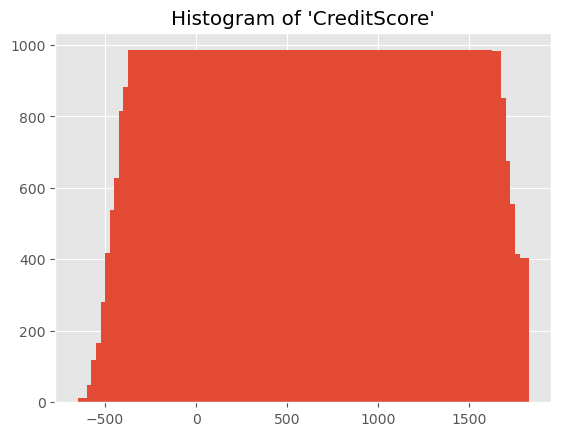

In [12]:
data = {'bins': hists[0][:-1],'freq': hists[1]}

plt.bar(data['bins'], data['freq'],width=2000)
plt.title('Histogram of \'CreditScore\'')

In [14]:
df_churn_model.where('CreditScore > 0').count()

10000

In [20]:
sc = spark.sparkContext
rdd = sc.parallelize(range(51))
rdd.histogram(2)

([0, 25, 50], [25, 26])

In [19]:
for i in range(0, 51):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [22]:
# c) Tiền xử lý dữ liệu, bao gồm: loại bỏ cột RowNumber, CustomerID, chuyển đổi giá 
# trị chuỗi thành số, chuyển đổi các biến độc lập thành vector.
df_churn_model_clean = df_churn_model.drop(df_churn_model['RowNumber'], 'CustomerId')
df_churn_model_clean.printSchema()

root
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [23]:
df_churn_model_clean.select('Gender').show()

+------+
|Gender|
+------+
|Female|
|Female|
|Female|
|Female|
|Female|
|  Male|
|  Male|
|Female|
|  Male|
|  Male|
|  Male|
|  Male|
|Female|
|Female|
|Female|
|  Male|
|  Male|
|Female|
|  Male|
|Female|
+------+
only showing top 20 rows



In [26]:
from pyspark.sql import functions as F
df_churn_model_clean = df_churn_model_clean.withColumn('Gender',F.when(F.col('Gender')=='Female',1).otherwise(2))
df_churn_model_clean.select(F.col('Gender')).show()
df_churn_model_clean.printSchema()

+------+
|Gender|
+------+
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
|     2|
+------+
only showing top 20 rows

root
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: integer (nullable = false)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [27]:
# Create du lieu

df = spark.createDataFrame([(1, 'Red'), (2, 'Red'), (3, 'Yellow'),(4, 'Green'), (5, 'Yellow')], ['Id','Color'])
df.show()
# Chuyen xau thanh so
import pyspark.sql.functions as f
import pyspark.sql.types as typ
dict = {'Red':0, 'Yellow':1, 'Green':2}
def convColor(str):
    return dict[str]
convC = f.udf(convColor,typ.IntegerType())
df = df.withColumn('Color_int',convC(f.col('Color')))
df.show()

+---+------+
| Id| Color|
+---+------+
|  1|   Red|
|  2|   Red|
|  3|Yellow|
|  4| Green|
|  5|Yellow|
+---+------+

+---+------+---------+
| Id| Color|Color_int|
+---+------+---------+
|  1|   Red|        0|
|  2|   Red|        0|
|  3|Yellow|        1|
|  4| Green|        2|
|  5|Yellow|        1|
+---+------+---------+



In [33]:
from pyspark.ml.feature import OneHotEncoder
oneHot = OneHotEncoder(inputCol='Color_int',outputCol='Color_OHE')
df2 = oneHot.fit(df).transform(df)
df.show()
df2.show()

+---+------+---------+
| Id| Color|Color_int|
+---+------+---------+
|  1|   Red|        0|
|  2|   Red|        0|
|  3|Yellow|        1|
|  4| Green|        2|
|  5|Yellow|        1|
+---+------+---------+

+---+------+---------+-------------+
| Id| Color|Color_int|    Color_OHE|
+---+------+---------+-------------+
|  1|   Red|        0|(2,[0],[1.0])|
|  2|   Red|        0|(2,[0],[1.0])|
|  3|Yellow|        1|(2,[1],[1.0])|
|  4| Green|        2|    (2,[],[])|
|  5|Yellow|        1|(2,[1],[1.0])|
+---+------+---------+-------------+



In [ ]:
# d) Chia dữ liệu thành tập huấn luyện và tập kiểm tra với tỉ lệ 70/30.
# e) Sử dụng Logistic Regression để huấn luyện mô hình dự đoán khách hàng có rời khỏi ngân hàng không?

In [41]:
(df_train, df_test) = df_churn_model_clean.randomSplit([0.7, 0.3])
print("Train dataset {0}".format(df_train.count()))
print("Test dataset {0}".format(df_test.count()))

Train dataset 6936
Test dataset 3064


In [42]:
df_train.show()

+----------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|   Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+----------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|     Abazu|        710|    Spain|     2| 28|     6|      0.0|            1|        1|             0|       48426.98|     0|
|     Abbie|        818|   France|     2| 31|     1|186796.37|            1|        0|             0|      178252.63|     0|
|    Abbott|        573|   France|     2| 33|     0| 90124.64|            1|        1|             0|      137476.71|     0|
|    Abbott|        645|   France|     2| 24|     3| 34547.82|            1|        1|             1|       11638.17|     0|
|    Abbott|        850|   France|     2| 29|     6|      0.0|            2|        1|             1|       10672.54|     0|


In [92]:
from pyspark.ml.feature import VectorAssembler
# Tạo cột đặc trưng từ các cột gender, balance và numTrans
assembler = VectorAssembler(inputCols=["Balance","HasCrCard","IsActiveMember","EstimatedSalary"],outputCol="features")
data = assembler.transform(df_churn_model_clean)
# Bo sung them trong so
data = data.withColumn("weight", F.when(f.col("Exited") == 1, 2).otherwise(1))
data = data.select("Balance","HasCrCard","IsActiveMember","EstimatedSalary","Exited","weight", "features")
data.show()

+---------+---------+--------------+---------------+------+------+--------------------+
|  Balance|HasCrCard|IsActiveMember|EstimatedSalary|Exited|weight|            features|
+---------+---------+--------------+---------------+------+------+--------------------+
|      0.0|        1|             1|      101348.88|     1|     2|[0.0,1.0,1.0,1013...|
| 83807.86|        0|             1|      112542.58|     0|     1|[83807.86,0.0,1.0...|
| 159660.8|        1|             0|      113931.57|     1|     2|[159660.8,1.0,0.0...|
|      0.0|        0|             0|       93826.63|     0|     1|  (4,[3],[93826.63])|
|125510.82|        1|             1|        79084.1|     0|     1|[125510.82,1.0,1....|
|113755.78|        1|             0|      149756.71|     1|     2|[113755.78,1.0,0....|
|      0.0|        1|             1|        10062.8|     0|     1|[0.0,1.0,1.0,1006...|
|115046.74|        1|             0|      119346.88|     1|     2|[115046.74,1.0,0....|
|142051.07|        0|           

In [93]:
from pyspark.ml.classification import LogisticRegression
# Xây dựng mô hình
lr = LogisticRegression(featuresCol="features", labelCol="Exited", weightCol="weight")
# Chia dữ liệu train và test
data_train, data_test = data.randomSplit([0.8, 0.2])
# Huấn luyện mô hình bằng dữ liệu train
model = lr.fit(data_train)

In [94]:
data_test.where('Balance> 0').show()

+--------+---------+--------------+---------------+------+------+--------------------+
| Balance|HasCrCard|IsActiveMember|EstimatedSalary|Exited|weight|            features|
+--------+---------+--------------+---------------+------+------+--------------------+
|38550.06|        0|             1|      179230.23|     0|     1|[38550.06,0.0,1.0...|
|40169.88|        1|             1|      199857.47|     0|     1|[40169.88,1.0,1.0...|
|41299.03|        0|             1|      102681.32|     0|     1|[41299.03,0.0,1.0...|
|43772.66|        1|             0|      187756.24|     1|     2|[43772.66,1.0,0.0...|
|45144.43|        1|             0|       60917.24|     1|     2|[45144.43,1.0,0.0...|
|45408.85|        1|             0|       18732.91|     0|     1|[45408.85,1.0,0.0...|
|45472.28|        1|             1|       41055.71|     1|     2|[45472.28,1.0,1.0...|
|46323.57|        1|             0|      136812.02|     0|     1|[46323.57,1.0,0.0...|
|46520.69|        1|             1|       9

In [95]:
test_model = model.transform(data_test)
test_model.show()

+-------+---------+--------------+---------------+------+------+------------------+--------------------+--------------------+----------+
|Balance|HasCrCard|IsActiveMember|EstimatedSalary|Exited|weight|          features|       rawPrediction|         probability|prediction|
+-------+---------+--------------+---------------+------+------+------------------+--------------------+--------------------+----------+
|    0.0|        0|             0|         735.79|     0|     1|  (4,[3],[735.79])|[0.74593993734459...|[0.67829338902200...|       0.0|
|    0.0|        0|             0|         3749.0|     1|     2|  (4,[3],[3749.0])|[0.74417908514247...|[0.67790903030959...|       0.0|
|    0.0|        0|             0|        5459.07|     1|     2| (4,[3],[5459.07])|[0.74317975866828...|[0.67769079021335...|       0.0|
|    0.0|        0|             0|        6139.74|     0|     1| (4,[3],[6139.74])|[0.74278199041834...|[0.67760390115217...|       0.0|
|    0.0|        0|             0|       

In [140]:
test_model.where('EstimatedSalary == 735.79').select('features').take(1)

[Row(features=SparseVector(4, {3: 735.79}))]

In [147]:
test_model.where('prediction > 0').take(1)

[Row(Balance=137430.82, HasCrCard=0, IsActiveMember=0, EstimatedSalary=176768.59, Exited=0, weight=1, features=DenseVector([137430.82, 0.0, 0.0, 176768.59]), rawPrediction=DenseVector([-0.0006, 0.0006]), probability=DenseVector([0.4998, 0.5002]), prediction=1.0)]

In [118]:
data.printSchema()

root
 |-- Balance: double (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)
 |-- weight: integer (nullable = false)
 |-- features: vector (nullable = true)



In [119]:
test_model.count()

2015

In [120]:
test_model.where((F.col('Exited') == F.col('prediction'))).count()

1562

In [102]:
1562/2015

0.7751861042183623

In [150]:
from pyspark.ml.linalg import Vectors,SparseVector,DenseVector
from pyspark.ml.feature import VectorAssembler

dataset = spark.createDataFrame(
    [(0, 18, 1.0, SparseVector(4, {3: 735.79}), 1.0)],
    ["id", "hour", "mobile", "userFeatures", "clicked"])

dataset.show()

+---+----+------+----------------+-------+
| id|hour|mobile|    userFeatures|clicked|
+---+----+------+----------------+-------+
|  0|  18|   1.0|(4,[3],[735.79])|    1.0|
+---+----+------+----------------+-------+



In [151]:
model.predict(SparseVector(4, {3: 735.79}))

0.0

In [154]:
model.predict(DenseVector([137430.82, 0.0, 0.0, 176768.59]))

1.0

In [155]:
model.predict(DenseVector([0, 0.0, 0.0, 735.79]))

0.0

In [156]:
from datetime import datetime, timedelta

# Lấy thời gian hiện tại và thêm 5 phút
execution_time = datetime.now() + timedelta(minutes=5)

# Chuyển sang định dạng chuỗi phù hợp
formatted_time = execution_time.strftime('%Y-%m-%dT%H:%M:%S')

print(formatted_time)

2024-09-22T08:44:15
